# deepSSAM prototype notebook

This notebook contains a prototype implementation of a deepSSAM neural network algorithm that uses a pre-trained neural network to generalize gene expression information to FITC/DAPI technology information.

#### Imports:

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
# from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
import anndata
import time

perf = time.perf_counter()
perf_ = perf

print(time.perf_counter()-perf)

9.300187230110168e-05


#### Parameter definition:

In [3]:
img_path_wall = '../../vizgen-merfish/vz-liver-showcase/Liver1Slice1/images/mosaic_Cellbound3_z4.tif'
img_path_dapi = '../../vizgen-merfish/vz-liver-showcase/Liver1Slice1/images/mosaic_DAPI_z4.tif'
coordinate_path = '../../../../raw_data/vizgen-merfish/vz-liver-showcase/Liver1Slice1/detected_transcripts.csv'

scale=1 # scaling factor for images/coordinats. We want to end up with cell diameter ~30px (cellpose default)
model_type='cyto2' # cellpose model name. ['dapi','cyto','cyto2']

In [4]:
# SSAM vector field resolution:
um_per_pixel = 2.5

# SSAM pandwidth:
bw = 1

# KNN diffusion iterations to move spots to z-axis zero mean:
z_centralization_iters = 20

# {0:'xenium_mouse_brain',1:'merfish_mouse_brain',2:'merfish_liver'}
dataset =0

file_root = '/dh-projects/ag-ishaque/analysis/tiesmeys/spot-data-z-axis-incoherence/src'


In [5]:
# Load coordinate_path data frame, read only the columns
# global_x, global_y, global_z, fov	gene:

perf_=time.perf_counter()

df = pd.read_csv(coordinate_path, sep=',', usecols=[2,3,4,8], header=0)[::1]

print(f'Loading time: {time.perf_counter()-perf_}')
perf_=time.perf_counter()



Loading time: 347.0410801023245


Pre-processing time: 159.4689108673483


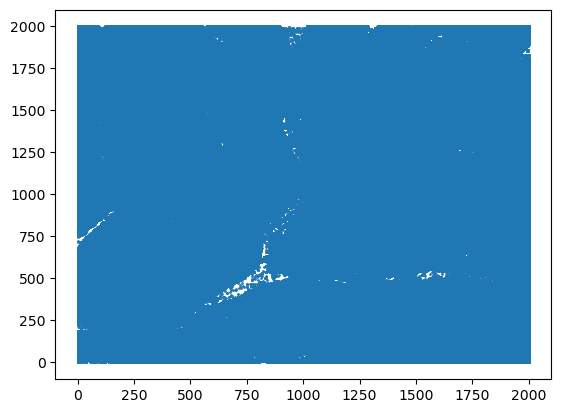

In [6]:
df.columns=['x','y','z','gene']

df = df[~df.gene.str.contains('Blank')]

df.x-=df.x.min()
df.y-=df.y.min()
df.x/=um_per_pixel/scale
df.y/=um_per_pixel/scale

df.gene = df.gene.astype('category')
gene_counts = df.gene.value_counts()
genes = gene_counts.index



x_lims = [1000,3000]
y_lims = [1000,3000]

df_mask = (df.x>x_lims[0]) & (df.x<x_lims[1]) & (df.y>y_lims[0]) & (df.y<y_lims[1])

df = df[df_mask]

df.x-=df.x.min()
df.y-=df.y.min()

print(f'Pre-processing time: {time.perf_counter()-perf_}')
perf_=time.perf_counter()

plt.scatter(df.x,df.y,s=1)

In [8]:
perf_=time.perf_counter()

from src import ovrlp

perf_=time.perf_counter()

roi_df = ovrlp.find_overlaps(df,threshold_fraction=0.4,density_weight=0.3,min_distance=20)

print(f'Ovrl.py runtime: {time.perf_counter()-perf_}')
perf_=time.perf_counter()

# re=run to compute divergence map:
_, _, divergence, signal, divergence_map = ovrlp.compute_divergence(df, genes, plot=False,
                                            threshold_fraction=0.4,density_weight=0.3,
                                            min_distance=20,return_maps=True)




Ovrl.py runtime: 216.38865762017667


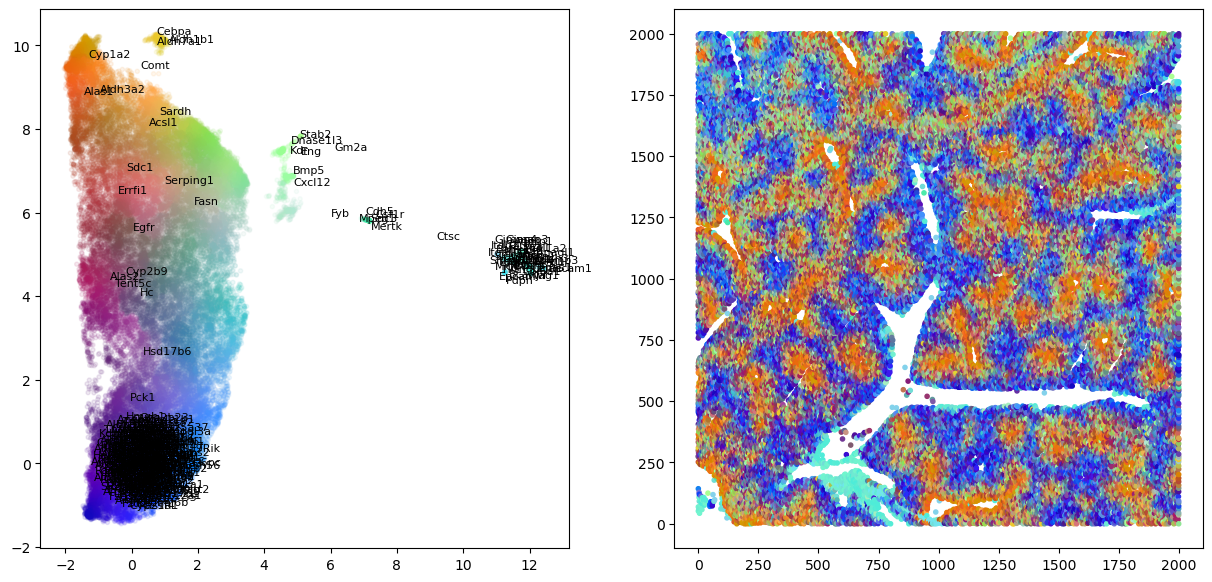

In [10]:
import random

perf_=time.perf_counter()

random.seed(42)

vis = ovrlp.Visualizer()

vis.fit(df)

print(f'SSAM/visualization runtime: {time.perf_counter()-perf_}')
perf_=time.perf_counter()

vis.plot_fit()

/tmp/ipykernel_1501493/286529475.py:28: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(['signal','incoherence'],[plt.scatter([],[],color=c) for c in ['b','r']])


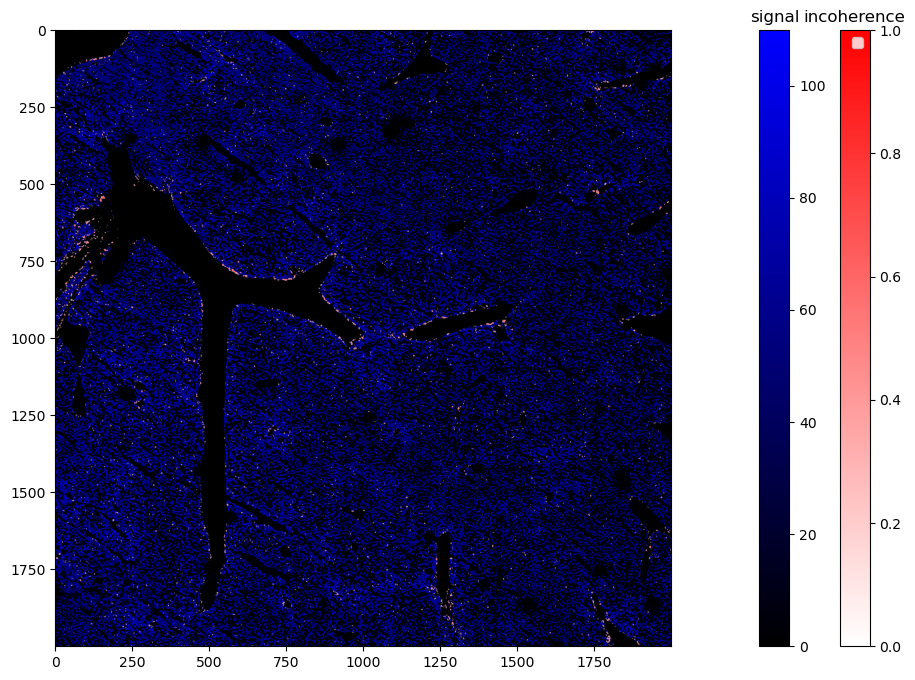

In [20]:
from matplotlib.colors import LinearSegmentedColormap


# rois_x, rois_y, divergence, signal, divergence_map = ovrlp.compute_divergence(spot_df_raw, genes, plot=False,
#                                             threshold_fraction=0.4,density_weight=0.3,
#                                             min_distance=20,return_maps=True)

BlGr = LinearSegmentedColormap.from_list('BlGr', ['black','blue'], N=256)
TrRd = LinearSegmentedColormap.from_list('TrRd', [[1.0,1.0,1.0,1.0],[1.0,0.0,0.0,1.0]], N=256)

f, (p, b1,b2) = plt.subplots(1, 3, width_ratios=[23, 1,1],figsize=(11,8))

handle_signal_alpha = (signal>(np.max(signal)/3)).astype(float)
handle_signal = p.imshow(signal,cmap=BlGr,alpha=handle_signal_alpha)
p.set_facecolor('black')

incoherence = divergence_map*signal
incoherence/=incoherence.max()
incoherence_alpha = (incoherence>(np.max(incoherence)/3)).astype(float)
handle_divergence = p.imshow(incoherence,cmap=TrRd,alpha=incoherence_alpha)

plt.colorbar(handle_signal,cax=b1)
plt.colorbar(handle_divergence,cax=b2)

b1.set_title('signal')
b2.set_title('incoherence')



instance visualization runtime: 319.30801688693464


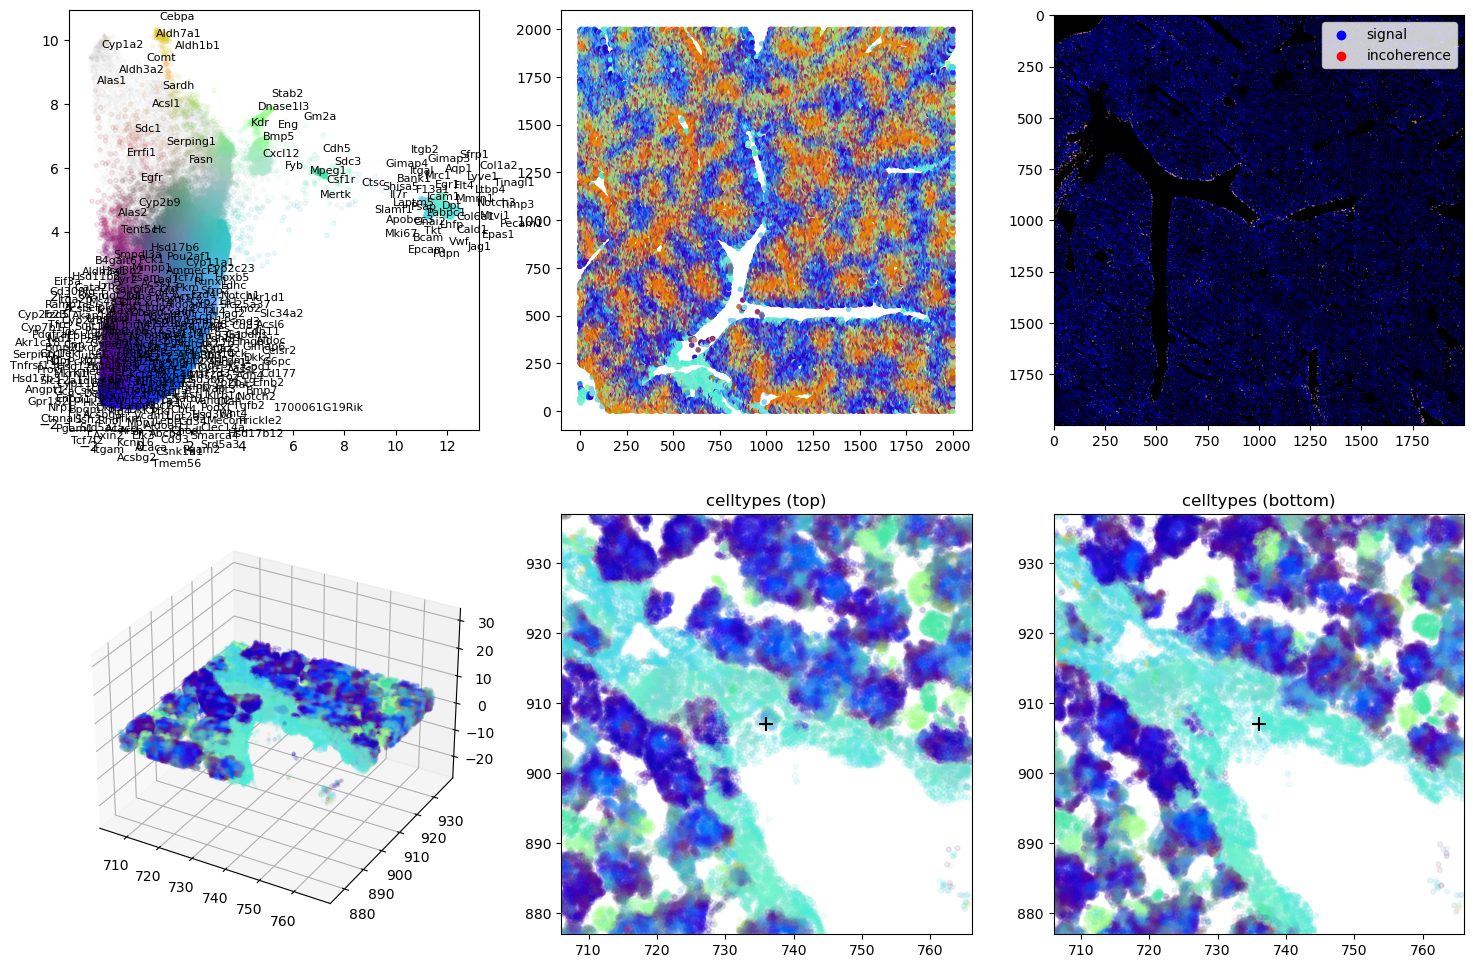

In [24]:
perf_=time.perf_counter()

vis.transform(*roi_df[['x','y']].iloc[0].values,df)

print(f'instance visualization runtime: {time.perf_counter()-perf_}')

plt.subplot(232)
vis.plot_tissue()

ax = plt.subplot(233)
plt.legend([plt.scatter([],[],color=c) for c in ['b','r']],['signal','incoherence'])

handle_signal = ax.imshow(signal,cmap=BlGr,alpha=handle_signal_alpha)
ax.set_facecolor('black')

handle_divergence = ax.imshow(incoherence,cmap=TrRd,alpha=incoherence_alpha)
ax.invert_yaxis()


In [ ]:
for i in range(1,5):
    
    vis.transform(*roi_df[['x','y']].iloc[i].values,df)

    plt.subplot(232)
    vis.plot_tissue()

    ax = plt.subplot(233)
    plt.legend([plt.scatter([],[],color=c) for c in ['b','r']],['signal','incoherence'])

    handle_signal = ax.imshow(signal,cmap=BlGr,alpha=handle_signal_alpha)
    ax.set_facecolor('black')

    handle_divergence = ax.imshow(incoherence,cmap=TrRd,alpha=incoherence_alpha)
    ax.invert_yaxis()